In this tutorial, we demonstrate how to use the vectorized and compilable likelihood as implemented in `jaxspec` in external samplers. We will use the [`zeus`](https://zeus-mcmc.readthedocs.io/en/latest/) sampler. Let's first import all the necessary packages and setup the basic configuration for `JAX`.

In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")

import arviz as az 
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import zeus
import jax
import jax.numpy as jnp
import numpy as np
from jaxspec.data.util import load_example_obsconf
from jaxspec.fit import NUTSFitter, BayesianModel
from jaxspec.model.additive import Powerlaw, Blackbodyrad
from jaxspec.model.multiplicative import Tbabs

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/sdupourque/opt/anaconda3/envs/jaxspec/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Now, instead of the casual [`NUTSFitter`](/references/fitting/#jaxspec.fit.NUTSFitter), we build a [`BayesianModel`](/references/fitting/#jaxspec.fit.BayesianModel), which is the parent class of any fitter implemented in `jaxspec`.

In [2]:
spectral_model = Tbabs()*(Powerlaw() + Blackbodyrad())

prior = {
    'powerlaw_1': {
        'alpha': dist.Uniform(0, 5),
        'norm': dist.LogUniform(1e-6, 1e-3)
    },
    'blackbodyrad_1': {
        'kT' : dist.Uniform(0.3, 3),
        'norm': dist.LogUniform(1e-2, 1e3)
    },
    'tbabs_1': {
        'N_H': 0.2
    }
}

ulx_observations = load_example_obsconf("NGC7793_ULX4_ALL")
bayesian_model = BayesianModel(spectral_model, prior, ulx_observations)

 The [`BayesianModel`](/references/fitting/#jaxspec.fit.BayesianModel) class exposes methods to compute the likelihood associated with any set of parameters. This likelihood function is a pure `JAX` function, so it can be freely nested with the `jit` or `vmap` operators. In the following cell, we also use the [`array_to_dict`](/references/fitting/#jaxspec.fit.BayesianModel.array_to_dict) method to build a compiled and vectorized likelihood function that accepts `numpy` arrays as input. We can use it with the `emcee` sampler and launch a MCMC run. 

In [3]:
ndim, nwalkers = len(bayesian_model.parameter_names), 8
p0 = np.array([[0.7, 0.2, 2, 3e-4]])*np.random.normal(loc=1, scale=0.1, size=(nwalkers, ndim))

@jax.jit
@jax.vmap
def zeus_log_prob(parameters: np.ndarray) -> jax.typing.ArrayLike:
    return bayesian_model.log_posterior_prob(bayesian_model.array_to_dict(parameters))

sampler = zeus.EnsembleSampler(
    nwalkers, ndim, zeus_log_prob, vectorize=True
)

sampler.run_mcmc(p0, 10_000, progress=True);

Initialising ensemble of 8 walkers...
Sampling progress : 100%|██████████| 10000/10000 [06:28<00:00, 25.74it/s]


Note how we initialized the chains close to the expected values. Now let's check the convergence of the chain using `arviz`.

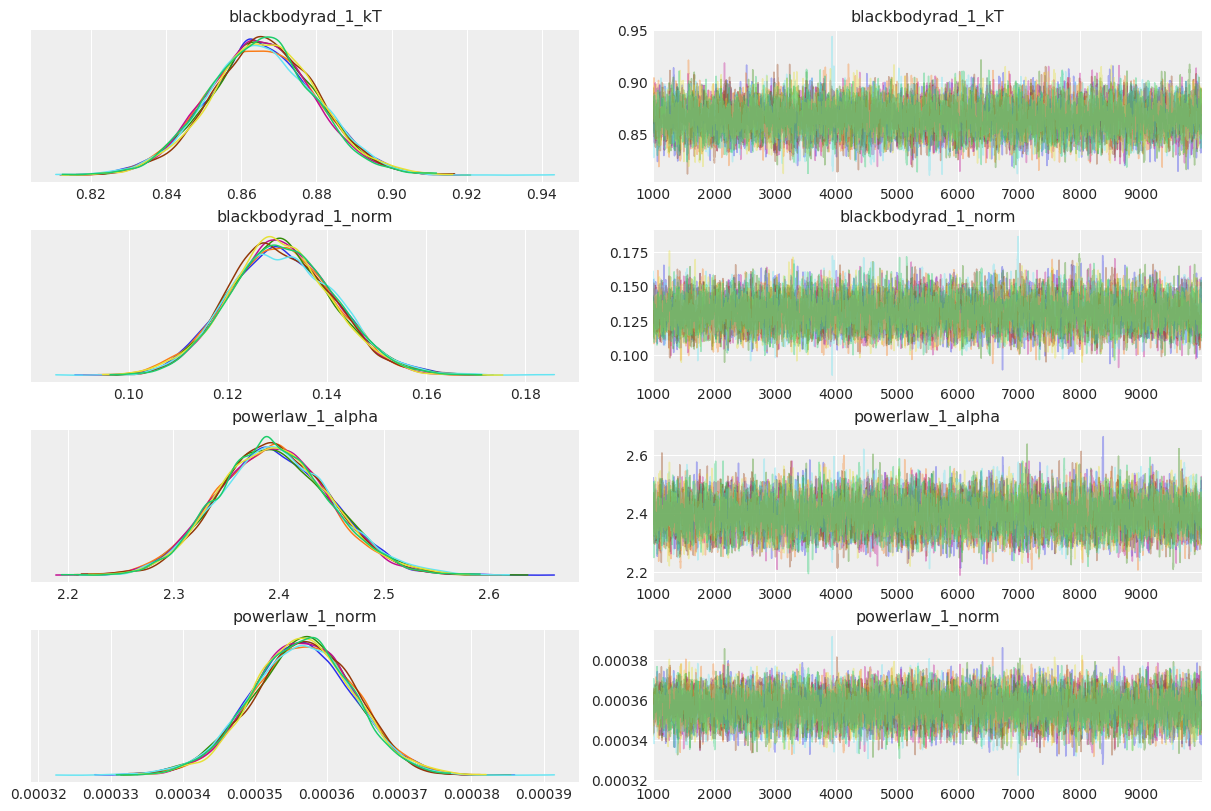

In [4]:
inference_data_emcee = az.from_emcee(sampler, var_names=bayesian_model.parameter_names).sel(draw=slice(1_000, None))

with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(inference_data_emcee, compact=False);

Everything seems fine, let's check wether or not the results are agreeing with what we would obtain using the No U-Turn Sampler. 

In [5]:
result = NUTSFitter(spectral_model, prior, ulx_observations).fit()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

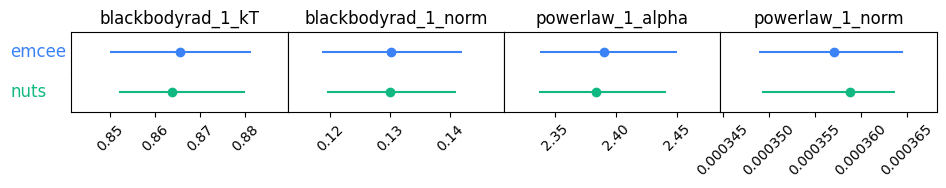

In [6]:
from chainconsumer import ChainConsumer, Chain, PlotConfig

chain_emcee = Chain.from_emcee(sampler, bayesian_model.parameter_names, "emcee")
chain_nuts = result.to_chain("nuts")

cc = ChainConsumer()
cc.set_plot_config(PlotConfig())
cc.add_chain(chain_emcee)
cc.add_chain(chain_nuts)

cc.plotter.plot_summary(errorbar=True, figsize=0.8)

for ax in plt.gcf().get_axes():
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()

We got equivalent results using `zeus` with few steps and a proper initialisation. The likelihood function we built can be fed with any kind of `numpy` or `JAX` arrays, and should be easy to use with your favorite framework.